In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 520

ng =8

ng_refs = (/ 3 , 2 , 3 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 1380

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66/

data wgt
     &     /0.55 , 0.55 , 0.85 , 0.85,
     &     0.85 , 0 , 0.3 , 0.55/

atmosphere_profiles/trp75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

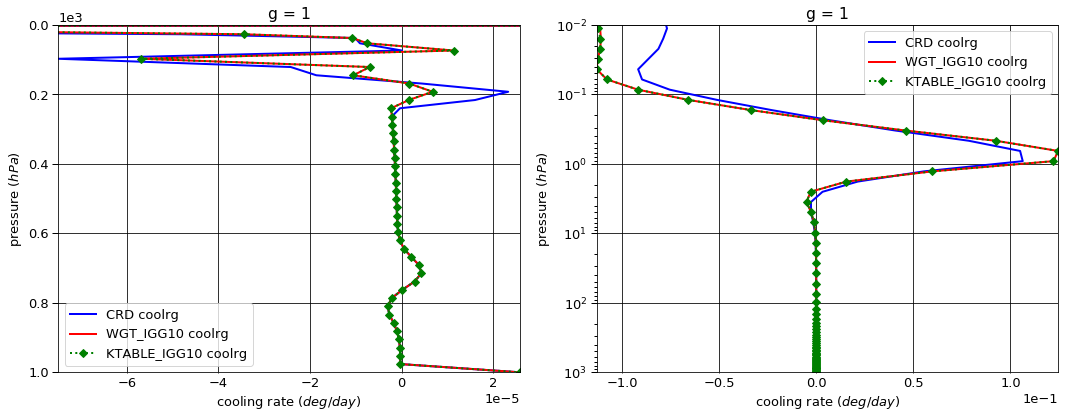

# Figure: cooling rate g-group 2

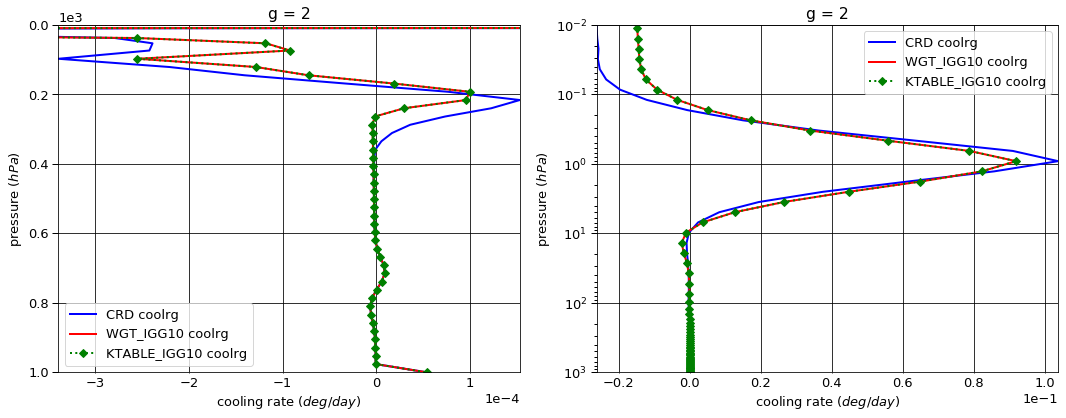

# Figure: cooling rate g-group 3

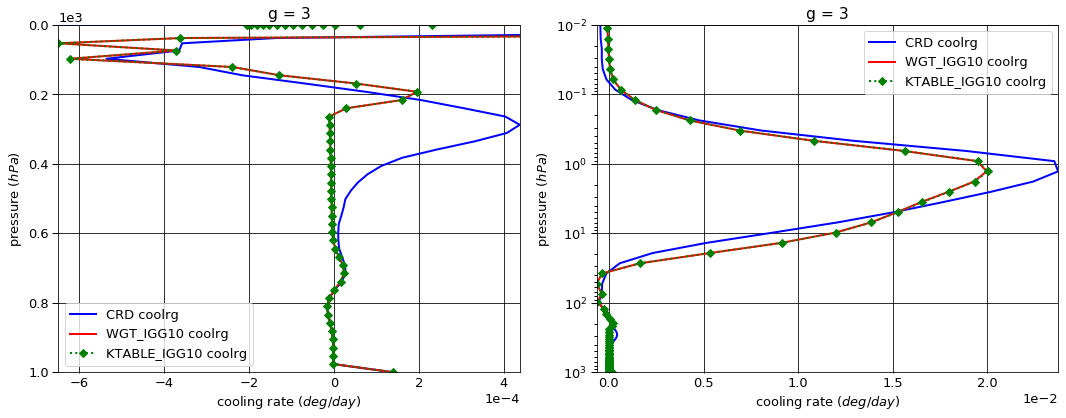

# Figure: cooling rate g-group 4

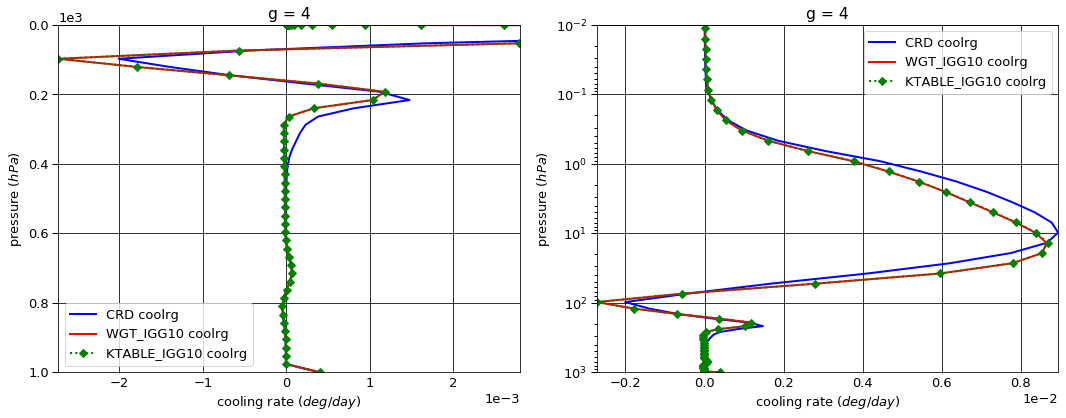

# Figure: cooling rate g-group 5

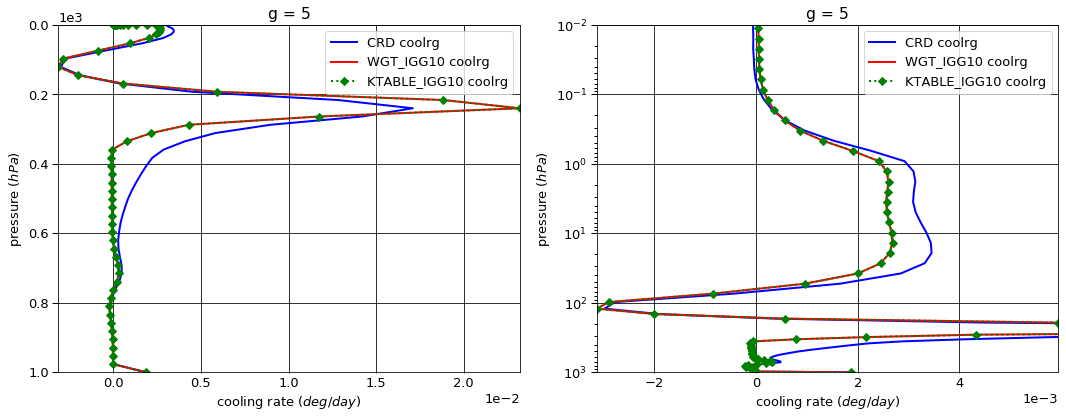

# Figure: cooling rate g-group 6

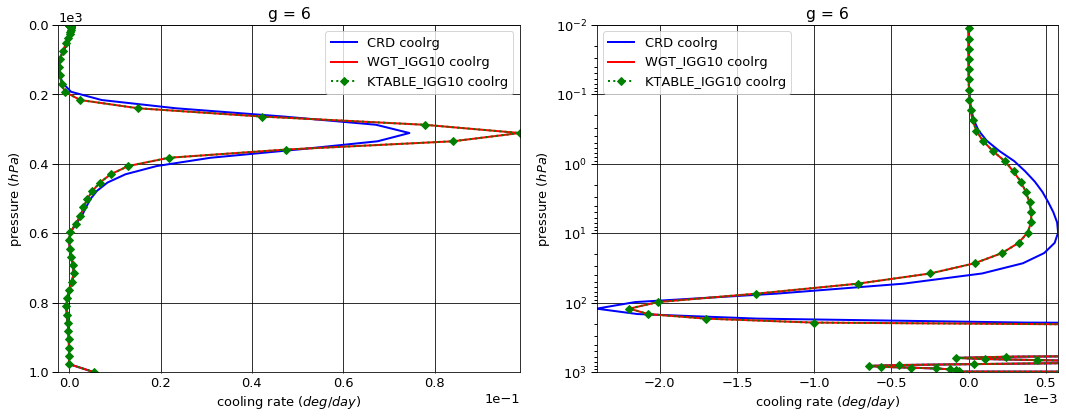

# Figure: cooling rate g-group 7

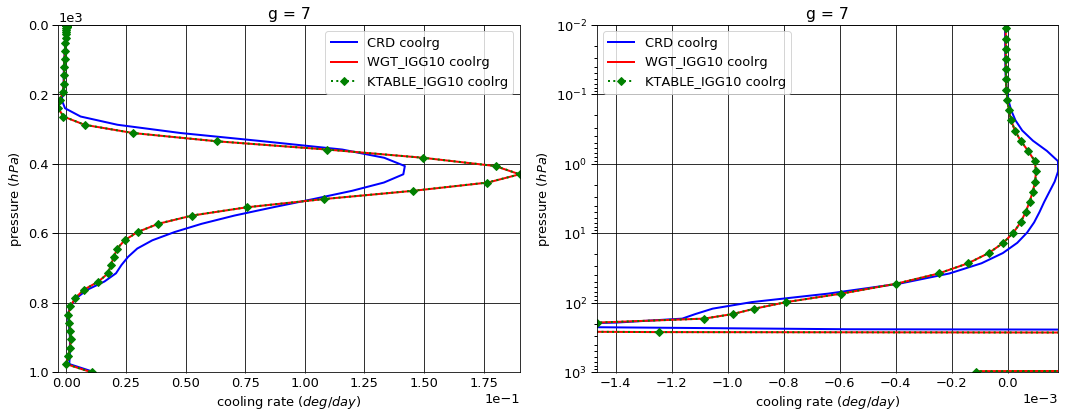

# Figure: cooling rate g-group 8

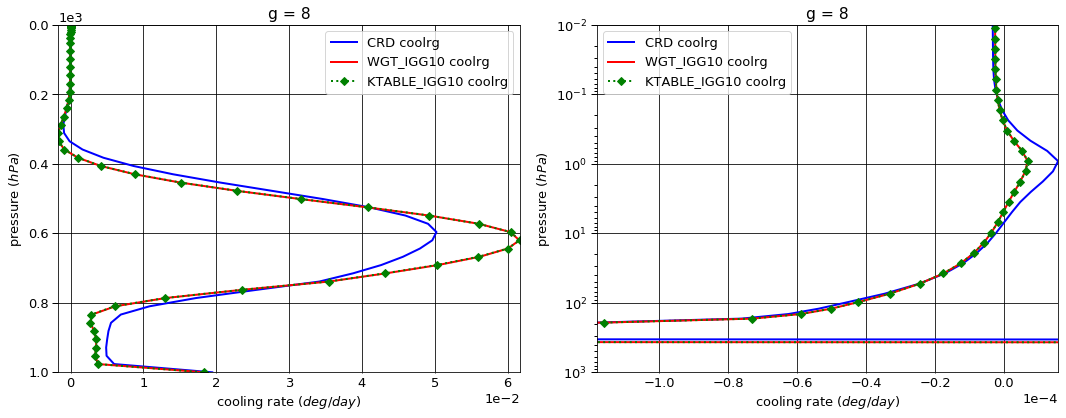

# Figure: cooling rate g-group total

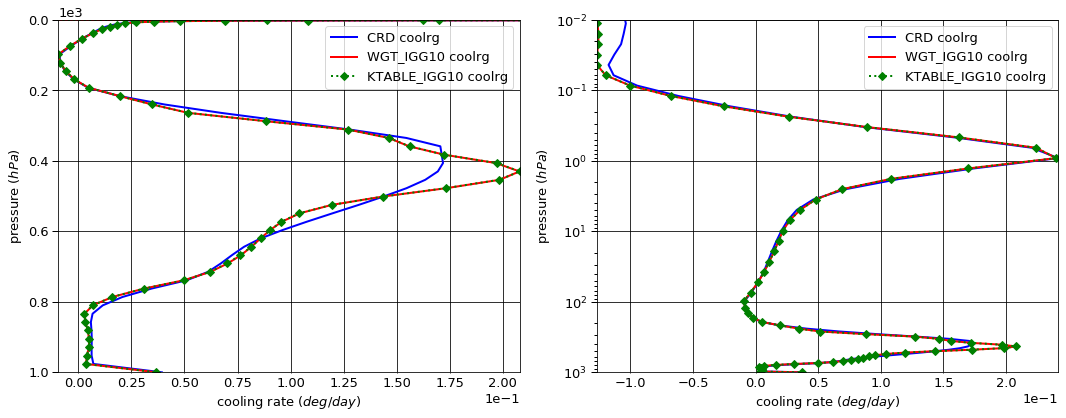

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009860   0.000000 -0.009860
  1013.0   76     -0.043086   0.043013 -0.000073
2 0.0      1      -0.021445   0.000000 -0.021445
  1013.0   76     -0.090246   0.090093 -0.000153
3 0.0      1      -0.027961   0.000000 -0.027961
  1013.0   76     -0.233319   0.232923 -0.000397
4 0.0      1      -0.040013   0.000000 -0.040013
  1013.0   76     -0.669480   0.668345 -0.001135
5 0.0      1      -0.242206   0.000000 -0.242206
  1013.0   76     -3.109608   3.104277 -0.005331
6 0.0      1      -1.208156   0.000000 -1.208156
  1013.0   76     -9.177424   9.161832 -0.015592
7 0.0      1      -4.209276   0.000000 -4.209276
  1013.0   76    -17.734956  17.702892 -0.032064
8 0.0      1      -1.934307   0.000000 -1.934307
  1013.0   76     -4.796914   4.733499 -0.063415


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.010055   0.000000 -0.010055
  1013.0   76     -0.043086   0.043013 -0.000073
2 0.0      1      -0.022449   0.000000 -0.022449
  1013.0   76     -0.090246   0.090093 -0.000153
3 0.0      1      -0.026249   0.000000 -0.026249
  1013.0   76     -0.233319   0.232923 -0.000397
4 0.0      1      -0.037297   0.000000 -0.037297
  1013.0   76     -0.669480   0.668345 -0.001135
5 0.0      1      -0.188054   0.000000 -0.188054
  1013.0   76     -3.109608   3.104335 -0.005273
6 0.0      1      -1.224909   0.000000 -1.224909
  1013.0   76     -9.177424   9.161832 -0.015592
7 0.0      1      -4.217940   0.000000 -4.217940
  1013.0   76    -17.734956  17.705034 -0.029922
8 0.0      1      -1.945621   0.000000 -1.945621
  1013.0   76     -4.796914   4.747020 -0.049893


KTABLE_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.010054   0.000000 -0.010054
  1013.0   76     -0.043086   0.043013 -0.000073
2 0.0      1      -0.022445   0.000000 -0.022445
  1013.0   76     -0.090246   0.090093 -0.000153
3 0.0      1      -0.026269   0.000000 -0.026269
  1013.0   76     -0.233319   0.232923 -0.000397
4 0.0      1      -0.037327   0.000000 -0.037327
  1013.0   76     -0.669480   0.668345 -0.001135
5 0.0      1      -0.187966   0.000000 -0.187966
  1013.0   76     -3.109608   3.104335 -0.005273
6 0.0      1      -1.224697   0.000000 -1.224697
  1013.0   76     -9.177424   9.161832 -0.015592
7 0.0      1      -4.216238   0.000000 -4.216238
  1013.0   76    -17.734956  17.705034 -0.029922
8 0.0      1      -1.944324   0.000000 -1.944324
  1013.0   76     -4.796914   4.747190 -0.049724


WGT_IGG10 - CRD


flug          fldg     fnetg
g pressure level                                      
1 0.0      1     -1.943977e-04  0.000000e+00 -0.000194
  1013.0   76     0.000000e+00 -6.938894e-18  0.000000
2 0.0      1     -1.004182e-03  0.000000e+00 -0.001004
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
3 0.0      1      1.712200e-03  0.000000e+00  0.001712
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
4 0.0      1      2.715208e-03  0.000000e+00  0.002715
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
5 0.0      1      5.415213e-02  0.000000e+00  0.054152
  1013.0   76     0.000000e+00  5.850000e-05  0.000059
6 0.0      1     -1.675250e-02  0.000000e+00 -0.016753
  1013.0   76    -1.776357e-15  0.000000e+00  0.000000
7 0.0      1     -8.663600e-03  0.000000e+00 -0.008664
  1013.0   76     0.000000e+00  2.142000e-03  0.002142
8 0.0      1     -1.131480e-02  0.000000e+00 -0.011315
  1013.0   76     0.000000e+00  1.352160e-02  0.013522


KTABLE_IGG10 - CRD


flug          fldg     fnetg
g pressure level                                      
1 0.0      1     -1.937757e-04  0.000000e+00 -0.000194
  1013.0   76     0.000000e+00 -6.938894e-18  0.000000
2 0.0      1     -1.000330e-03  0.000000e+00 -0.001000
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
3 0.0      1      1.692253e-03  0.000000e+00  0.001692
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
4 0.0      1      2.685186e-03  0.000000e+00  0.002685
  1013.0   76     0.000000e+00  0.000000e+00  0.000000
5 0.0      1      5.424005e-02  0.000000e+00  0.054240
  1013.0   76     0.000000e+00  5.850000e-05  0.000059
6 0.0      1     -1.654090e-02  0.000000e+00 -0.016541
  1013.0   76    -1.776357e-15  0.000000e+00  0.000000
7 0.0      1     -6.961600e-03  0.000000e+00 -0.006962
  1013.0   76     0.000000e+00  2.142000e-03  0.002142
8 0.0      1     -1.001750e-02  0.000000e+00 -0.010017
  1013.0   76     0.000000e+00  1.369140e-02  0.013691

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -9.143660e-02
  1001.112500 75     2.582176e-05
2 0.000312    1     -2.827525e-02
  1001.112500 75     5.388226e-05
3 0.000312    1     -6.326984e-04
  1001.112500 75     1.399492e-04
4 0.000312    1     -7.977073e-06
  1001.112500 75     4.005261e-04
5 0.000312    1     -8.507197e-05
  1001.112500 75     1.884461e-03
6 0.000312    1     -9.144778e-07
  1001.112500 75     5.502194e-03
7 0.000312    1     -9.942125e-06
  1001.112500 75     1.189969e-02
8 0.000312    1     -3.446216e-06
  1001.112500 75     1.944900e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.241659e-01
  1001.112500 75     2.582176e-05
2 0.000312    1     -1.610611e-02
  1001.112500 75     5.388226e-05
3 0.000312    1     -2.443702e-04
  1001.112500 75     1.399492e-04
4 0.000312    1      8.640431e-06
  1001.112500 75     4.005261e-04
5 0.000312    1      2.141254e-05
  1001.112500 75     1.860771e-03
6 0.000312    1     -8.866519e-07
  1001.112500 75     5.502194e-03
7 0.000312    1     -7.178545e-06
  1001.112500 75     1.056077e-02
8 0.000312    1     -2.660814e-06
  1001.112500 75     1.833481e-02


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.275429e-01
  1001.112500 75     2.582176e-05
2 0.000312    1     -1.582448e-02
  1001.112500 75     5.388226e-05
3 0.000312    1     -2.040014e-04
  1001.112500 75     1.399492e-04
4 0.000312    1      4.121862e-06
  1001.112500 75     4.005261e-04
5 0.000312    1      1.922717e-05
  1001.112500 75     1.860771e-03
6 0.000312    1     -3.435652e-07
  1001.112500 75     5.502194e-03
7 0.000312    1     -6.363636e-06
  1001.112500 75     1.056077e-02
8 0.000312    1     -2.527815e-06
  1001.112500 75     1.826953e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.272929e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      1.216914e-02
  1001.112500 75     0.000000e+00
3 0.000312    1      3.883281e-04
  1001.112500 75     0.000000e+00
4 0.000312    1      1.661750e-05
  1001.112500 75     0.000000e+00
5 0.000312    1      1.064845e-04
  1001.112500 75    -2.368930e-05
6 0.000312    1      2.782589e-08
  1001.112500 75     0.000000e+00
7 0.000312    1      2.763580e-06
  1001.112500 75    -1.338920e-03
8 0.000312    1      7.854021e-07
  1001.112500 75    -1.114185e-03


KTABLE_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.610627e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      1.245077e-02
  1001.112500 75     0.000000e+00
3 0.000312    1      4.286970e-04
  1001.112500 75     0.000000e+00
4 0.000312    1      1.209894e-05
  1001.112500 75     0.000000e+00
5 0.000312    1      1.042991e-04
  1001.112500 75    -2.368930e-05
6 0.000312    1      5.709126e-07
  1001.112500 75     0.000000e+00
7 0.000312    1      3.578489e-06
  1001.112500 75    -1.338920e-03
8 0.000312    1      9.184014e-07
  1001.112500 75    -1.179468e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.693224,0.000000,-7.693224
1013.0,76,-35.855033,35.736874,-0.118159



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.672574,0.000000,-7.672574
1013.0,76,-35.855033,35.752596,-0.102437



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.669320,0.000000,-7.669320
1013.0,76,-35.855033,35.752766,-0.102267



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.02065,0.000000,0.020650
1013.0,76,0.00000,0.015722,0.015722



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.023903,0.000000,0.023903
1013.0,76,0.000000,0.015892,0.015892


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.120452
1001.112500,75,0.039356



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.140497
1001.112500,75,0.036879



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.143557
1001.112500,75,0.036813



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.020045
1001.112500,75,-0.002477



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.023105
1001.112500,75,-0.002542


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001154,0.001196
2,0.002433,0.002525
3,0.006375,0.006475
4,0.017817,0.018636
5,0.083269,0.086563
6,0.248308,0.254744
7,0.479058,0.498801
8,0.161587,0.131059


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.262964e-18
2,2.786366e-19
3,1.821229e-20
4,1.179072e-20
5,7.724450e-22
6,2.503686e-21
7,1.649401e-22
8,1.086608e-23


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.262964e-18,NaN,0.001154,0.001196,0.001154,0.001196,1.0
2,2.786366e-19,0.065362,0.002433,0.002525,0.003587,0.003721,1.0
3,1.821229e-20,0.065362,0.006375,0.006475,0.009962,0.010196,1.0
4,1.179072e-20,0.647404,0.017817,0.018636,0.027779,0.028832,10.0
5,7.724450e-22,0.065513,0.083269,0.086563,0.111048,0.115395,10.0
6,2.503686e-21,3.241249,0.248308,0.254744,0.359356,0.370140,500.0
7,1.649401e-22,0.065879,0.479058,0.498801,0.838413,0.868941,500.0
8,1.086608e-23,0.065879,0.161587,0.131059,1.000000,1.000000,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.544117e-17  8.163471e-18   1.891496  8.418216e-04
      2 0.000312     9.080355e-19  4.282497e-19   2.120341  4.789098e-05
      3 0.000312     2.352266e-20  1.033905e-20   2.275127  1.490781e-06
      4 0.000312     3.357512e-22  2.455329e-22   1.367439  2.229540e-08
      5 0.000312     2.352725e-22  6.676095e-23   3.524103  1.453033e-08
      6 0.000312     1.234785e-24  1.188385e-24   1.039044  8.222846e-11
      7 0.000312     2.615952e-24  1.297761e-24   2.015742  1.171596e-10
      8 0.000312     1.836956e-24  1.972295e-25   9.313795  7.604904e-11
2     1 0.000750     1.544086e-17  8.173163e-18   1.889215  3.391913e-04
      2 0.000750     9.110582e-19  4.296683e-19   2.120376  1.935397e-05
      3 0.000750     2.364690e-20  1.039178e-20   2.275539  6.036303e-07
      4 0.000750     3.392339e-22  2.486121e-22   1.364511  9.075666e-09
      5 0.000750     2.359229e-22  6.703684e-23   3.519302  5.869184e-09
      6 0.000750     1.249773e-24  1.203097e-24   1.038797  3.353054e-11
      7 0.000750     2.625448e-24  1.302906e-24   2.015071  4.737008e-11
      8 0.000750     1.839335e-24  1.978624e-25   9.296031  3.067594e-11
3     1 0.001052     1.544031e-17  8.192696e-18   1.884643  4.760087e-04
      2 0.001052     9.171502e-19  4.324915e-19   2.120620  2.732235e-05
      3 0.001052     2.388494e-20  1.048026e-20   2.279040  8.549492e-07
      4 0.001052     3.438539e-22  2.524571e-22   1.362029  1.290361e-08
      5 0.001052     2.371007e-22  6.743312e-23   3.516087  8.272312e-09
      6 0.001052     1.268203e-24  1.220987e-24   1.038670  4.772199e-11
      7 0.001052     2.643565e-24  1.312146e-24   2.014688  6.689636e-11
      8 0.001052     1.844097e-24  1.990278e-25   9.265525  4.314238e-11
4     1 0.001476     1.543952e-17  8.212373e-18   1.880032  6.682506e-04
      2 0.001476     9.233516e-19  4.353738e-19   2.120825  3.858844e-05
      3 0.001476     2.413217e-20  1.057525e-20   2.281949  1.211705e-06
      4 0.001476     3.490889e-22  2.569036e-22   1.358832  1.838293e-08
      5 0.001476     2.383427e-22  6.786897e-23   3.511807  1.166663e-08
      6 0.001476     1.289518e-24  1.241748e-24   1.038470  6.808714e-11
      7 0.001476     2.662437e-24  1.321874e-24   2.014139  9.453219e-11
      8 0.001476     1.849059e-24  2.002394e-25   9.234237  6.070362e-11
5     1 0.002070     1.543850e-17  8.231924e-18   1.875442  9.379129e-04
      2 0.002070     9.295827e-19  4.382820e-19   2.120970  5.448785e-05
      3 0.002070     2.438678e-20  1.067733e-20   2.283977  1.717344e-06
      4 0.002070     3.551014e-22  2.621267e-22   1.354694  2.623695e-08
      5 0.002070     2.396470e-22  6.835409e-23   3.505964  1.645432e-08
      6 0.002070     1.314575e-24  1.266240e-24   1.038172  9.738173e-11
      7 0.002070     2.681943e-24  1.332080e-24   2.013349  1.335891e-10
      8 0.002070     1.854169e-24  2.014918e-25   9.202206  8.540160e-11
6     1 0.002904     1.543721e-17  8.251343e-18   1.870873  1.316512e-03
      2 0.002904     9.358465e-19  4.412218e-19   2.121034  7.694654e-05
      3 0.002904     2.465057e-20  1.078865e-20   2.284862  2.434973e-06
      4 0.002904     3.621814e-22  2.684141e-22   1.349338  3.755452e-08
      5 0.002904     2.410315e-22  6.890772e-23   3.497889  2.321701e-08
      6 0.002904     1.344801e-24  1.295892e-24   1.037742  1.397999e-10
      7 0.002904     2.702236e-24  1.342914e-24   2.012219  1.888653e-10
      8 0.002904     1.859446e-24  2.027986e-25   9.168928  1.201726e-10
7     1 0.004074     1.543563e-17  8.270626e-18   1.866320  1.847950e-03
      2 0.004074     9.421491e-19  4.442025e-19   2.120990  1.086661e-04
      3 0.004074     2.492608e-20  1.091273e-20   2.284128  3.453971e-06
      4 0.004074     3.707367e-22  2.761775e-22   1.342385  5.395719e-08
      5 0.004074     2.425217e-22  6.955689e-23   3.486667  3.277463e-08
      6 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
